## feature selection and prediction testing for miRNA data

references:

Y. Taguchi and Y. Murakami, “Principal component analysis based feature extraction approach to identify circulating microRNA biomarkers.,” PLoS One, vol. 8, no. 6, p. e66714, 2013.


In [24]:
import glob,os
import pandas as pd
import numpy as np
import mirnaseq.mirdeep2 as mdp
from mirnaseq import base, analysis
pd.set_option('display.width', 130)
%matplotlib inline
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D
base.seabornsetup()
plt.rcParams['savefig.dpi']=80
plt.rcParams['font.size']=16
home = os.path.expanduser("~")

In [55]:
#iconmap data
path = os.path.join(home,'mirnaseq/data/iconmap/analysis/')
os.chdir(path)
respath = 'iconmap_results_mirdeep'
ic = mdp.getResults(respath)
ic = mdp.filterExprResults(ic,meanreads=150,freq=0.8)
k = ic[ic.novel==False]
condmap = mdp.getLabelMap(respath,'samplelabels.csv')
condmap = condmap.sort('id')

labels=['control','infected']
y=condmap.status.values 
#labels=[0,6]
#y=condmap.month.values

In [92]:
#douwe data 
path = os.path.join(home,'mirnaseq/data/douwe/analysis/')
os.chdir(path)
respath = 'douwe_mirdeep_rnafiltered'
ic = mdp.getResults(respath)
ic = mdp.filterExprResults(ic,meanreads=150,freq=0.8)
k = ic[ic.novel==False]
condmap = mdp.getLabelMap(respath,'samplelabels.csv')
condmap = condmap.sort('id')
#labels=['Neg','Pos']
#y=condmap.ELISA.values 
labels=['CTRL','MAP']
y=condmap.infection.values
#labels=['START','EARLY','LATE']
#y=condmap.timegroup.values
#labels=[1,2]
#y=condmap.pool.values 
print condmap[:5]


    pool        cond  sample                    filename infection timepoint timegroup  month  animal ELISA   id
9      1  MAP TP END      10  miRNA_lib_Pool1_Sample_10_       MAP       END      LATE     49    1351   Pos  s01
10     1  MAP TP END      11  miRNA_lib_Pool1_Sample_11_       MAP       END      LATE     49    1355   Neg  s02
11     1  MAP TP END      12  miRNA_lib_Pool1_Sample_12_       MAP       END      LATE     49    1360   Neg  s03
12     1    MAP 6 PI      13  miRNA_lib_Pool1_Sample_13_       MAP        6P     EARLY      6    1351   Pos  s04
13     1    MAP 6 PI      14  miRNA_lib_Pool1_Sample_14_       MAP        6P     EARLY      6    1355   Neg  s05


In [93]:
#use normalised columns
scols = condmap.id+'(norm)'

df = k.set_index('#miRNA')
X=df[scols].T
X=X.dropna(axis=1)
X=X.drop_duplicates()
X=X.values

In [94]:
#standardize data
from sklearn import preprocessing
#scaler = preprocessing.StandardScaler().fit(X)
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)

In [95]:
def plot3D(X):
    
    fig = plt.figure(figsize=(8,6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1])
    for c, i in zip("brgyc", labels):
        ax.scatter(X[y == i, 0], X[y == i, 1], X[y == i, 2], c=c, s=100, label=i)
    plt.legend()

    for label in labels:
        ax.text3D(X[y == label, 0].mean(),
                  X[y == label, 1].mean() + 1.5,
                  X[y == label, 2].mean(), label,
                  horizontalalignment='center',
                  bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))


In [96]:
def doPCA(X):
    #do PCA
    from sklearn.decomposition.pca import PCA, RandomizedPCA
    from sklearn.lda import LDA

    pca = PCA(n_components=5)
    pca.fit(X)
    print pca.explained_variance_ratio_
    Xt = pca.fit_transform(X)

    plt.figure(figsize=(6,6))
    for c, i in zip("brgyc", labels):
        plt.scatter(Xt[y == i, 0], Xt[y == i, 1], c=c, s=100, label=i, alpha=0.8)
    plt.xlabel('PC1')    
    plt.ylabel('PC2')
    plt.legend() 
    plot3D(Xt)
    return Xt

In [97]:
def plotClassification(cl, X):
    plt.figure(figsize=(6,6))

    X = X[:, :2]
    cl.fit(X, y)
    h = .04
    e=0.1
    x_min, x_max = X[:, 0].min() - e, X[:, 0].max() + e
    y_min, y_max = X[:, 1].min() - e, X[:, 1].max() + e
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = cl.predict(np.c_[xx.ravel(), yy.ravel()])
    #get cats as integers
    Z = pd.Categorical(Z).labels
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)

    for c, i in zip("brgyc", labels):
        plt.scatter(X[y == i, 0], X[y == i, 1], c=c, s=100, label=i, lw=2)
    plt.legend()

In [98]:
#test classifiers using first n features

def classify(X):

    np.random.seed()
    ind = np.random.permutation(len(X))

    Xtrain = X[ind[:-15]]
    ytrain = y[ind[:-15]]
    Xtest = X[ind[-15:]]
    ytest = y[ind[-15:]]

    from sklearn import linear_model
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier()
    logit = linear_model.LogisticRegression(C=1e5)

    knn.fit(Xtrain, ytrain) 
    logit.fit(Xtrain, ytrain) 
    cl = knn

    ypred = cl.predict(Xtest)
   
    from sklearn.metrics import classification_report, accuracy_score
    print classification_report(ytest, ypred)
    #print accuracy_score(ytest, ypred)

    from sklearn import cross_validation   
    yy = pd.Categorical(y).labels    

    #sc = cross_validation.cross_val_score(knn, X, yy, scoring='roc_auc', cv=5)
    
    plotClassification(knn, X)    
    return knn

[ 0.19944385  0.12986672  0.11056592  0.08932552  0.05305144]


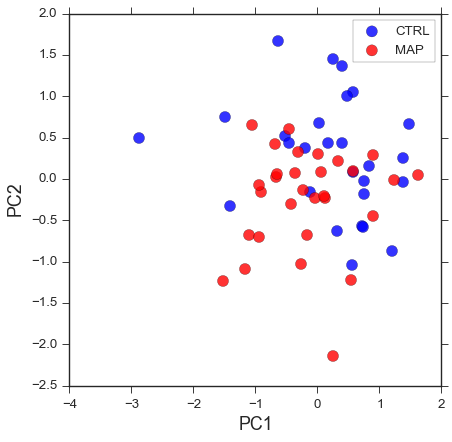

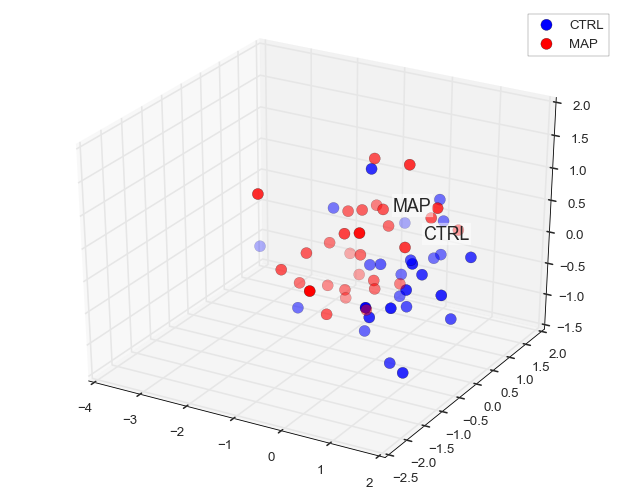

In [99]:
Xt = doPCA(X)

             precision    recall  f1-score   support

       CTRL       0.60      1.00      0.75         6
        MAP       1.00      0.56      0.71         9

avg / total       0.84      0.73      0.73        15

             precision    recall  f1-score   support

       CTRL       1.00      0.67      0.80         9
        MAP       0.67      1.00      0.80         6

avg / total       0.87      0.80      0.80        15



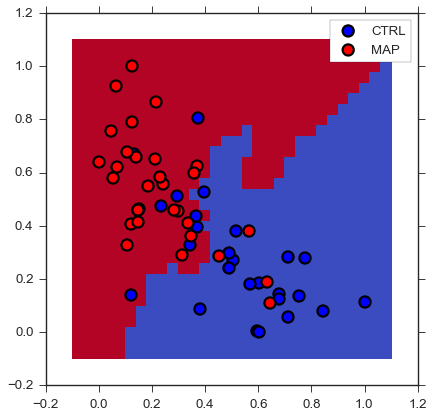

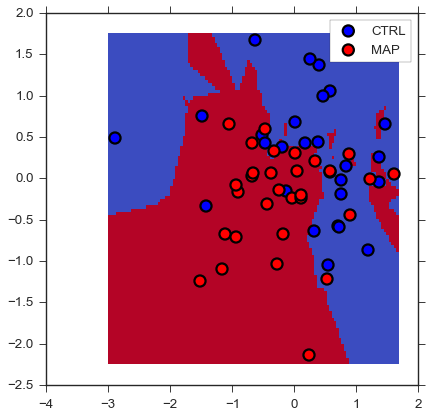

In [100]:
cl = classify(X)
cl2 = classify(Xt)

15


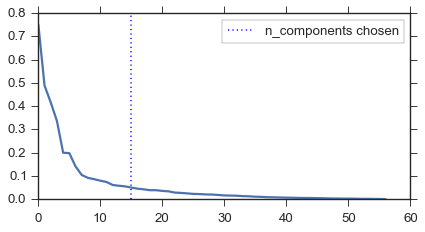

In [101]:
#using a pipeline to find best no. of principle components as features for prediction

pca = RandomizedPCA()
pca.fit(X)

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
pipe = Pipeline(steps=[('pca', pca), ('knn', cl)])
components = range(3,30,2)
Cs = np.logspace(-4, 4, 3)
params = dict(pca__n_components=components) #,logistic__C=Cs)
est = GridSearchCV(pipe, params, cv=3) 
est.fit(X, y)
print est.best_estimator_.named_steps['pca'].n_components

plt.figure(figsize=(6,3))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axvline(est.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend()

In [ ]:
lda = LDA(n_components=3)
Xl = lda.fit(X, y).transform(X)
fig = plt.figure(figsize=(6,6))
for c, i in zip("grb", labels):
    plt.scatter(Xl[y == i, 0], Xl[y == i, 1], c=c, s=100, label=i)
plt.legend()
#plt.xlabel('PC1')    
#plt.ylabel('PC2')